# Rekurentne neuronske mreže

Glavna karakteristika neuronskih mreža koje ste dosad videli, kao što su gusto povezane mreže i konvolutivne mreže, jeste da nemaju memoriju. Svaki ulazni podatak se obrađuje nezavisno, bez čuvanja stanja između ulaza. Ukoliko bismo hteli da obradimo sekvencijalne podatke, morali bismo čitavu sekvencu prikazati mreži odjednom: pretvoriti je u jedan podatak. Na primer, ukoliko bismo hteli da klasifikujemo video, sve slike iz videa bismo spojili u jednu veliku sliku, čime bismo izgubili njihovu vremensku zavisnost.

Rekurentna neuronska mreža (RNN) obrađuje sekvencu iterirajući kroz njene elemente i pritom održavajući stanje koje sadrži informacije o tome šta je do sada videla. Stanje omogućava da RNN uči i razume kontekstualne zavisnosti u sekvencijalnim podacima, što je ključno za zadatke poput predviđanja vremensih serija, klasifikacije ili generisanja teksta.

Na slici 1. prikazano je kako se sve može iskoristiti RNN za rad sa sekvencama, kao i razlika u odnosu na feed-forward mreže.

<figure>
  <img src=./img/rnn_arch.jpeg" alt="RNN" width="2048">
  <figcaption>Slika 1.</figcaption>
</figure>
<p>
Svaki pravougaonik predstavlja vektor, a strelice predstavljaju funkcije (na primer, množenje matrica). Ulazni vektori su crveni, izlazni vektori su plavi, a zeleni vektori čuvaju stanje rekurentne neuronske mreže. Sleva nadesno:

1) Osnovni način obrade bez rekurentne neuronske mreže (feed-forward), ulaz i izlaz su fiksne veličine (na primer, klasifikacija slika).
2) Fiksan ulaz, sekvenca na izlazu (na primer, generisanje opisa na osnovu slike. Ulaz je slika, a izlaz lista reči koje je opisuju).
3) Sekvenca na ulazu, fiksan izlaz (na primer, analiza sentimenta gde se data rečenica klasifikuje kao izražavanje pozitivnog ili negativnog sentimenta).
4) Sekvence na ulazu i izlazu (na primer, mašinsko prevođenje sa jednog jezika na drugi).
5) Sinhronizovana sekvenca ulaza i izlaza (na primer, klasifikacija videa gde želimo označiti svaki kadar videa).
    </p>
</p>

Na slici 2. prikazan je sloj rekurentne neuronske mreže u kompakntom i razvijenom obliku. Možemo primetiti da sloj rekurentne mreže ima dva izlaza i da se jedan od izlaza propagira u sledeći korak sa novim ulazom. Taj izlaz predstavlja skriveno stanje mreže.

Pre nego što nastavimo, tebali bismo definisati simbole sa slike:
1. $x$ - ulazna sekvenca (niz reči, niz slika,...)
2. $h$ - skriveno stanje.
3. $o$ - je izlaz, može biti jedna vrednost ili sekvenca
4. $U$ - matrica težina na ulazu
5. $W$ - matrica težina na skrivenom stanju
6. $V$ - matrica težina na izlazu

<figure>
  <img src="./img/rnn.png" alt="RNN unrolled" width="1920">
  <figcaption>Slika 2.</figcaption>
</figure>

Kako bismo izračunali izlaze rekurentnog sloja, uvodimo tri matrice težina $U, W, V$. Matricu $U$ čine težine pridružene ulaznim podacima, dok matrice $W$ i $V$ čine težine pridružene podacima iz skrivenog sloja, a koriste se za računanje novog skrivenog sloja i izlaza, respektivno.

Izlaz iz skrivenog sloja, u vremenskom trenutku t, računa se na sledeći način:
$h_t = tanh(x_tU^T + b_{u} + h_{t-1}W^T + b_{w})$

Ulaz u trenutku $t$, $x_t$ množi sa matricom $U$, čime mreža iz ulaza izdvaja ono što joj je potrebno. Takođe, izlaz iz skrivenog sloja u prethodnom koraku $h_{t-1}$ se množi sa matricom $W$, čime mreža prenosi informacija iz prethodnog stanja u trenutno. Na kraju se zbir ova dva množenja prosleđuje $tanh$ aktivacionoj funkciji, kako bismo uveli nelinearnost u sistem i takođe skalirali brojeve između $[-1,1]$.

Izlaz iz sloja, u vremenskom trenutku t, računa se na sledeći način:
$o_t = activation(h_tV^T + b_{V})$
Izlaz iz trenutnog skrivenog sloja $h_{t}$ se množi sa matricom $V$ i prosleđuje aktivacionoj funkciji, čime mreža izlaz skrivenog sloja transformiše u izlaznu vrednost.


### Vannila RNN

U ovom terminu vežbi ćemo implementirati tzv. "Vanilla" RNN, koji čini osnovni primer rekurentne mreže. Zbog problema koje mogu nastati prilikom treniranja ovog tipa mreže, u praksi se češće koriste nešto kompleksije varijacije rekurentnih mreža, kao što su LSTM i GRU.

##### Definicija mreže
Iskoristićemo *torch* biblioteku da definišemo sloj rekurentne neuronske mreže. Sloj definišemo kao torch modul koji kao parametre očekuje veličinu ulaza (input_size), veličinu skrivenog stanja (hidden size) i veličinu izlaza (output_size). Ove veličine koristimo prilikom definisanja slojeva u rekurentnoj neuronskoj mreži, koji predstavljaju matrice težina $U, W, V$ i aktivacionu funkciju; $i2h = U$, $h2h = W$, $h2o = V$.

U funkciji $forward$ definišemo operacije nad definisanim slojevima u skladu sa formulama za $h_t$ i $o_t$.

In [724]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size # dimenzija skrivenog sloja
        self.i2h = nn.Linear(input_size, hidden_size) # matrica U
        self.h2h = nn.Linear(hidden_size, hidden_size) # matrica W
        self.h2o = nn.Linear(hidden_size, output_size) # matrica V
        self.softmax= nn.LogSoftmax(dim=1) # aktivaciona funkcija iskorišćena zbog klasifikacije imena

    def forward(self, input, hidden=None):
        if hidden is None: # ukoliko nije prosleđeno prethodno stanje, inicijalizuj stanje na 0 vektor
            hidden = torch.zeros(1, self.hidden_size)

        hidden = F.tanh(self.i2h(input) + self.h2h(hidden)) # računanje h_t
        output = self.h2o(hidden) # računanje o_t
        output = self.softmax(output) # računanje o_t
        return output, hidden


# Primer: Klasifikacija imena

U **names.csv** dat nam je skup ličnih imena i država čijeg su porekla, naš zadatak je da za dato ime odredimo državu kojoj pripada.

Na početku, učitavamo podatke i ispisujemo nekoliko nasumičnih primera, kako bismo stekli utisak o tome kako nam skup podataka izgleda.

In [725]:
import pandas as pd

# učitavamo skup podataka u pandas dataframe
df = pd.read_csv("./data/names.csv")

# prikazujemo nasumično nekoliko primera iz skupa
# funkcija sample na nasumičan način uzorkuje primere iz skupa, parametar frac definiše procenat primera koji želimo da uzorkujemo
df.sample(frac=0.1).head()

,language,name
110,arabic,Basara
7481,german,Neuman
495,arabic,Hanania
5344,english,Meredith
8569,italian,Lecce


Pošto rešavamo klasifikacioni problem, želimo da vidimo koje sve klase postoje. *Kod* ispod izvlači sve jezike i ispisuje ih zajedno sa ukupnim brojem jezika.

In [726]:
# Iz skupa preuzimamo skup svih jezika
languages = sorted(df['language'].unique())
num_of_labels = len(languages)

print("Broj jezika: ", num_of_labels)
print("Jezici: ", languages)

Broj jezika:  18
Jezici:  ['arabic', 'chinese', 'czech', 'dutch', 'english', 'french', 'german', 'greek', 'irish', 'italian', 'japanese', 'korean', 'polish', 'portuguese', 'russian', 'scottish', 'spanish', 'vietnamese']


Nakon što smo izvukli broj klasa, želimo da saznamo koliko primera imamo po klasi. Time, saznajemo da li nam je skup podataka izbalansiran ili ne (da li ima sličan broj primera po klasi). U zavisnosti od toga da li je skup podataka izbalansiran ili ne, odlučujemo kako da izbalansiramo skup podataka i odlučujemo koje ćemo metrike performansi koristiti, tačnost, F1, itd.

In [727]:
# Broj primera po jeziku
# Vidimo da skup podataka nije izbalansiran
df.groupby("language").count()

,name
language,
arabic,2000
chinese,268
czech,519
dutch,297
english,3668
french,277
german,724
greek,203
irish,232


Vidimo da skup podataka nije izbalansiran, što znači da bismo trebali da ga izbalansiramo na neki način i da koristimo F1 meru, a ne tačnost. Međutim, jednostavnosti radi, u ovom primeru se kao metrika se koristi tačnost, a o balansiranju će biti reči u nastavku.

**Reprezentacija teksta**
Nakon što smo se upoznali sa skupom podataka vreme je za definisanje vektorske reprezentacije teksta. U ovom primeru ćemo koristiti one-hot encoding reprezentaciju na nivou karaktera. One-hot encoding vektor sadrži vrednosti 0 i 1, gde se 1 nalazi na tačno jednom mestu, dok su ostale vrednosti 0. Veličina ovakvog vektora je definisana veličinom korišćenog vokabulara.

Primer:
Na osnovu vokabulara **['a', 'b', 'c', 'd']** kreirali bismo sledeće vektore:
**a** = [1,0,0,0]
**b** = [0,1,0,0]
**c** = [0,0,1,0]
**d** = [0,0,0,1]

U ovom primeru, vokabular definišemo kao skup ASCII slova i nekoliko specijalnih karaktera. Veličina vokabulara biće iskorišćena za definisanje dimenzije one-hot encoding vektora, svakog karaktera u skupu podataka.

In [728]:
import string

# definisanje vokabulara (sadrži samo ASCII slova i " .,;'")
vocab = string.ascii_letters + " .,;'"

# veličina vektora je određena brojem karaktera u vokabularu
vocab_size = len(vocab)


In [729]:
"""
Pomoćne funkcije za transformaciju reči u tensor.
"""
def letter_to_index(letter):
    """
    Vraća indeks karaktera u vokabularu.
    :param letter: karakter
    :return: indeks karaktera
    """
    return vocab.find(letter)


def letter_to_tensor(letter):
    """
    Vraća one-hot encoding tensor od karaktera.
    :param letter: karakter
    :return: torch.Tensor
    """
    tensor = torch.zeros(1, vocab_size)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


def line_to_tensor(line):
    """
    Vraća listu one-hot encoding tensora za svaki karakter.
    :param letter: karakter
    :return: torch.Tensor
    """

    tensor = torch.zeros(len(line), 1, vocab_size)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor


def label_to_tensor(label, labels):
    return torch.tensor([labels.index(label)], dtype=torch.long)


def output_to_category(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return languages[category_i], category_i


###### Primer korišćenja funkcije za transformaciju karaktera u tensor

In [730]:
print("Indeks slova P: ", letter_to_index("P"))

t = letter_to_tensor("P")
print("One-hot encoding slova P: ")
print(t)
print("Dimenzije tensora:", letter_to_tensor("P").size())

Indeks slova P:  41
One-hot encoding slova P: 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
Dimenzije tensora: torch.Size([1, 57])


###### Primer korišćenja funkcije za transformaciju imena u tensor.

In [731]:
t = line_to_tensor("Pera")
print("Tensor imena Pera")
print("Dimenzije tensora:", t.size())
print(t)

Tensor imena Pera
Dimenzije tensora: torch.Size([4, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

###### Funkcija za pretvaranje Unicode karaktera u ASCII

Pošto naš vokabular podržava samo ASCII karaktere, sve ostale karaktere želimo da pretvorimo u ASCII karaktere. Za to ćemo iskoristiti funkciju **unicode_to_ascii(s)**

In [732]:
import unicodedata
def unicode_to_ascii(s):
    """
    Pretvara prosleđeni utf-8 string u ASCII string.
    :param s: utf-8 string
    :return: ASII string
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in vocab
    )


In [733]:
# pretvaramo sve utf-8 karaktere u ascii karaktere pošto samo njih podržavamo u vokabularu
df['name'] = df['name'].apply(lambda n: unicode_to_ascii(n))

###### Funkcija za kreiranje trening i validacionog skupa
Definišemo funkciju kojom, prvo na slučajan način promešamo sve primere i zatim ih podelimo u dva skupa. Ove skupove ćemo koristiti kao trening i validacioni skup podataka.

In [ ]:
def train_test_split(df, test_split):
    train_size = len(df) - round(test_split * len(df))
    df = df.sample(frac=1)
    train = df[:train_size]
    test = df[train_size:]

    X_train = train['name'].apply(lambda n: line_to_tensor(n))
    y_train = train['language'].apply(lambda l: label_to_tensor(l, languages))
    X_test = test['name'].apply(lambda n: line_to_tensor(n))
    y_test = test['language'].apply(lambda l: label_to_tensor(l, languages))

    return X_train, y_train, X_test, y_test

In [734]:
# delimo podatke na trening i validacioni skup
X_train, y_train, X_valid, y_valid = train_test_split(df, 0.2)

##### Dodeljivanje težina klasama
Pošto skup podataka nije izbalansiran, da bismo ga izbalansirali svakoj klasi pridružujemo težinu, tako da klase sa manjim brojem primera imaju veću težinu, a one sa većim brojem primera, manju težinu. Na taj način govorimo mreži da više vrednuje ili kažnjava greške kod klasa sa manjim brojem primera, kako bi što bolje naučila njihovo ponašanje.

In [741]:
label_weight_map = df.groupby("language").count().apply(lambda l: 1/l).to_dict()['name']
label_weights = torch.tensor([label_weight_map[l] for l in languages])
label_weights

tensor([0.0005, 0.0037, 0.0019, 0.0034, 0.0003, 0.0036, 0.0014, 0.0049, 0.0043,
        0.0014, 0.0010, 0.0106, 0.0072, 0.0135, 0.0001, 0.0100, 0.0034, 0.0137])

##### Treniranje modela

Da bismo trenirali model potrebno je da ga kreiramo, definišemo funkciju greške i optimizer. Za funkciju greške biramo **NLLLoss()**, koja se koristi prilikom višeklasne klasifikacije, a kao optimizer ćemo koristiti **Adam-a**.

In [749]:
# veličina skrivenog sloja
n_hidden = 128
# broj epoha
epochs = 5
# learning rate
lr = 0.005

# definišemo funkciju greške
loss_fn = nn.NLLLoss(weight=label_weights)

# kreiramo model
model = RNN(vocab_size, n_hidden, num_of_labels)

# definišemo optimizer
optimizer = torch.optim.Adam(params=model.parameters())

###### Funkcija za treniranje jedne sekvence

1. Na početku se inicijalizuje skriveno stranje na None, što će prouzrokovati kreiranje 0 vektora za skriveno stanje i na taj način se resetuje skriveno stanje za svaki primer.
2. Nakon toga, uklanjamo gradijente iz prethodnog koraka i počinjemo forward pass kroz sekvencu
3. Nakon što model pozovemo nad svakim elementom sekvence, računamo grešku.
4. Nakon računanje greške, radi se backward pass i ažuriraju se težine.


In [750]:
"""
Funkcije za treniranje, predikciju i evaluaciju modela.
"""

def train(category_tensor: torch.Tensor, line_tensor: torch.Tensor):
    hidden = None
    model.train()
    optimizer.zero_grad()
    # line tensor
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()


# funkcija radi forward pass kroz ime i vraća izlaz
def predict(line_tensor):
    model.eval()
    hidden = None
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output


# funkcija računa tačnost modela
def evaluate(X, y):
    model.eval()
    total_acc, total_count = 0, 0

    for idx, (text, label) in enumerate(zip(X,y)):
        predicted_label = predict(text)
        a = (predicted_label.argmax(1) == label).sum().item()
        total_acc += a
        total_count += label.size(0)
    return total_acc / total_count


##### Trening petlja

U svakoj epohi dešava se sledeće:
1. Za svaki primer u trening skupu radi se jedna iteracija, nakon koje se računa greška
2. Greška se ispisuje na svakih 1000 iteracija
3. Nakon što se prođe trening skup, računa se greška na validacionom skupu

In [751]:
plot_every = 1000
all_losses = []
current_loss = 0


iter = 1
for epoch in range(epochs):
    model.train()

    for idx, row in X_train.items():
        output, loss = train(y_train[idx], row)
        current_loss += loss
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            print(f"Epoch {epoch}, Training loss {current_loss/plot_every}")
            current_loss = 0
        iter+=1

    valid_loss = 0
    accuracy = 0
    total_count = 0

    model.eval()

    for idx, row in X_valid.items():
        hidden = None

        for i in range(row.size()[0]):
            output, hidden = model(row[i], hidden)

        loss = loss_fn(output, y_valid[idx])
        valid_loss += loss.item()

        accuracy += (output.argmax(1) == y_valid[idx]).sum().item()
        total_count += y_valid[idx].size(0)

    print(f"Epoch: {epoch}, validation loss: {valid_loss/len(X_valid)}. Accuracy: {accuracy/total_count}")

Epoch 0, Training loss 1.5903006613617763
Epoch 0, Training loss 1.382766824531369
Epoch 0, Training loss 1.2521564139841357
Epoch 0, Training loss 1.1519633486109087
Epoch 0, Training loss 1.1913611776842445
Epoch 0, Training loss 1.1349184265287187
Epoch 0, Training loss 1.0997411833814112
Epoch 0, Training loss 1.1243477101399912
Epoch 0, Training loss 1.0739969505233458
Epoch 0, Training loss 1.0995024520609296
Epoch 0, Training loss 1.0652575050143058
Epoch 0, Training loss 1.0126738440281187
Epoch 0, Training loss 1.0419710675138631
Epoch 0, Training loss 0.9746550410466444
Epoch 0, Training loss 1.063861818425299
Epoch 0, Training loss 1.0213555213714134
Epoch: 0, validation loss: 1.0334453088039945. Accuracy: 0.6901618929016189
Epoch 1, Training loss 0.9846744964491517
Epoch 1, Training loss 0.9416453259850095
Epoch 1, Training loss 0.9355094778020575
Epoch 1, Training loss 0.9591042774079251
Epoch 1, Training loss 0.977234396329819
Epoch 1, Training loss 0.9675450344018464
Epo

Nakon što smo završili obučavanje mreže, želimo da ispišemo kretanje greške, kako bismo saznali da li naša mreža uči.

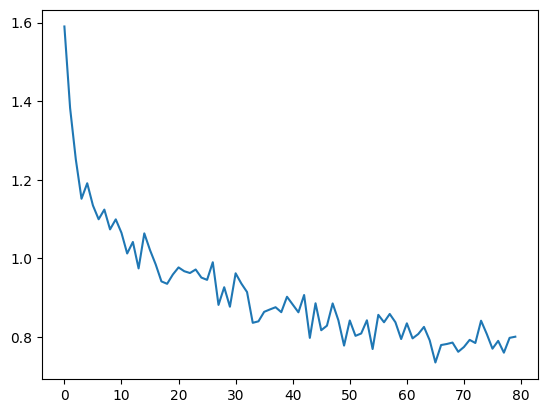

In [752]:
import matplotlib.pyplot as plt

# Crtamo grafik kretanja loss funkcije kroz iteracije
plt.figure()
plt.plot(all_losses)

###### Pikaz predikcije jednog nasumičnog imena

In [753]:
output = predict(line_to_tensor("Leonardo"))

In [754]:
output_to_category(output)

('spanish', 16)

###### Računamo tačnost modela

In [755]:
accuracy = evaluate(X_valid, y_valid)
accuracy

0.7471980074719801

### Zadatak: Analiza vremenske serije

Dat je skup podataka koji opisuje broj avio putnika na mesečnom nivou u periodu od januara 1949. do decembra 1960. Na osnovu godine i meseca potrebno je predvideti broj putnika u jedinicama od 1.000. Ovo je problem regresije. Drugim rečima, na osnovu broja putnika (u jedinicama od 1.000) u prethodnim mesecima, cilj je predvideti broj putnika u narednom mesecu. Skup podataka ima samo jednu osobinu: Broj putnika.

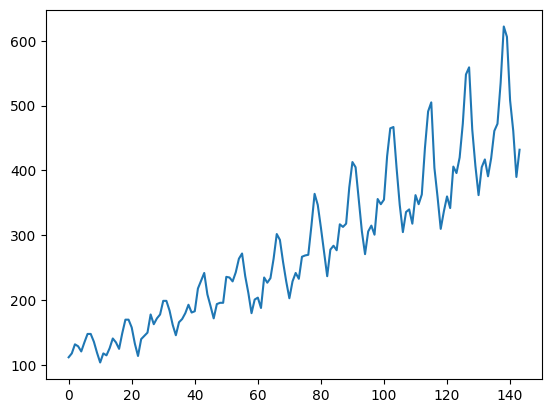

In [757]:
import pandas as pd
df = pd.read_csv('data/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

Data vam je pomoćna funkcija koja kreira sekvence sa *lookback* brojem elemenata. Na primer, ukoliko želite da gledate 3 meseca unazad, stavićete da lookback bude 3 i kao rezultat ćete dobiti niz primera sekvenci sa po 3 elementa.

In [761]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i + lookback]
        target = dataset[i + 1:i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [764]:
# prikazujemo samo prvi primer
create_dataset(timeseries, 3)[0]

tensor([[[112.],
         [118.],
         [132.]],

        [[118.],
         [132.],
         [129.]],

        [[132.],
         [129.],
         [121.]],

        [[129.],
         [121.],
         [135.]],

        [[121.],
         [135.],
         [148.]],

        [[135.],
         [148.],
         [148.]],

        [[148.],
         [148.],
         [136.]],

        [[148.],
         [136.],
         [119.]],

        [[136.],
         [119.],
         [104.]],

        [[119.],
         [104.],
         [118.]],

        [[104.],
         [118.],
         [115.]],

        [[118.],
         [115.],
         [126.]],

        [[115.],
         [126.],
         [141.]],

        [[126.],
         [141.],
         [135.]],

        [[141.],
         [135.],
         [125.]],

        [[135.],
         [125.],
         [149.]],

        [[125.],
         [149.],
         [170.]],

        [[149.],
         [170.],
         [170.]],

        [[170.],
         [170.],
         [15